# Import library

In [1]:
import torch
from torchvision import datasets, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, copy
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến tập train và test
train_path = '.\\Combined Dataset\\train'
test_path = '.\\Combined Dataset\\test'

train_dataset = datasets.ImageFolder(train_path)
test_dataset = datasets.ImageFolder(test_path)

# Kiểm tra kích thước của dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 10240
Test dataset size: 1279


# Show some images from dataset

Các nhãn trong tập dữ liệu: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


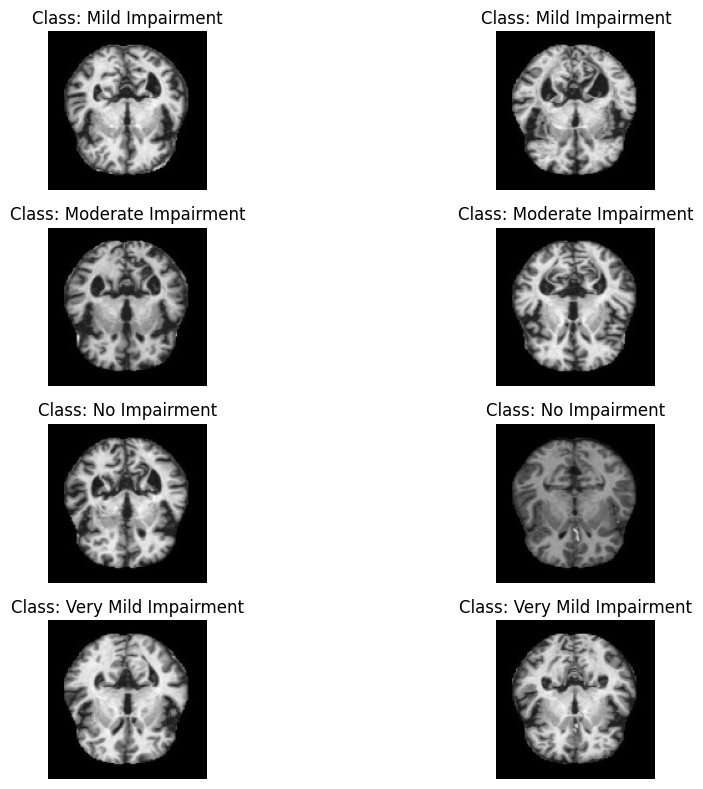

In [2]:
# Danh sách nhãn từ ImageFolder
labels = train_dataset.classes
print("Các nhãn trong tập dữ liệu:", labels)

# Dictionary to store images for each class
images_by_class = {label: [] for label in range(len(labels))}

# Iterate over the dataset to find 2 images per class
for image, label in train_dataset:
    if len(images_by_class[label]) < 2:  # Collect up to 2 images per class
        images_by_class[label].append(image)
    if all(len(images) == 2 for images in images_by_class.values()):  # Stop when all classes have 2 images
        break

# Plot images from all classes
plt.figure(figsize=(12, 8))
for class_idx, (label, images) in enumerate(images_by_class.items()):
    for img_idx, image in enumerate(images):
        plt.subplot(len(labels), 2, class_idx * 2 + img_idx + 1)
        
        # If the image is a PyTorch tensor, convert it to NumPy
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
        
        plt.imshow(image)
        plt.title(f"Class: {labels[label]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Data preproccesing and loading

In [3]:
# Batch size
bs = 64
# Number of epochs
num_epochs = 30
# Number of classes
num_classes = 4
# Number of workers (CPU threads)
num_cpu = 10
# Model saving path
PATH = "c:\\Users\HanDong\\Documents\\Study\\Spring 2025\\DAP391m"

# Applying transforms to the data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}
 
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_path, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=test_path, transform=image_transforms['valid'])
}
 
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

# Create iterators for data loading
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=num_cpu, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                            num_workers=num_cpu, pin_memory=True, drop_last=True)
}

# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)
 
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Training-set size: 10240 
Validation-set size: 1279


# Training

## ResNet50

In [4]:
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a custom model 
print("Loading ResNet50 for training from scratch ...\n")
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading ResNet50 for training from scratch ...



Using cache found in C:\Users\HanDong/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Summary:

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.0.conv3.weight True
10 layer1.0.bn3.weight True
11 layer1.0.bn3.bias True
12 layer1.0.downsample.0.weight True
13 layer1.0.downsample.1.weight True
14 layer1.0.downsample.1.bias True
15 layer1.1.conv1.weight True
16 layer1.1.bn1.weight True
17 layer1.1.bn1.bias True
18 layer1.1.conv2.weight True
19 layer1.1.bn2.weight True
20 layer1.1.bn2.bias True
21 layer1.1.conv3.weight True
22 layer1.1.bn3.weight True
23 layer1.1.bn3.bias True
24 layer1.2.conv1.weight True
25 layer1.2.bn1.weight True
26 layer1.2.bn1.bias True
27 layer1.2.conv2.weight True
28 layer1.2.bn2.weight True
29 layer1.2.bn2.bias True
30 layer1.2.conv3.weight True
31 layer1.2.bn3.weight True
32 layer1.2.bn3.bias True
33 layer2.0.conv1.weight True
34 layer2.0.bn1.weight True
35 layer2.0.bn

In [5]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Model training routine
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    train_accuracy = []
    train_losses = []
    val_accuracy = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize storage for predictions and labels
    all_preds = []
    all_labels = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Store predictions and labels in the validation phase
                if (phase == 'valid') and (epoch == num_epochs - 1) :
                    all_preds.append(preds.cpu().numpy())
                    all_labels.append(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # Record training loss and accuracy for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracy.append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Concatenate all batches' predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accuracy, train_losses, val_accuracy, val_losses, all_preds, all_labels

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + 'ResNet50_model.pth')

Training:

Epoch 0/29
----------
train Loss: 1.4503 Acc: 0.4706
valid Loss: 2.3072 Acc: 0.4738

Epoch 1/29
----------
train Loss: 0.9814 Acc: 0.5313
valid Loss: 1.0340 Acc: 0.5098

Epoch 2/29
----------
train Loss: 0.9295 Acc: 0.5515
valid Loss: 0.9216 Acc: 0.5160

Epoch 3/29
----------
train Loss: 0.9188 Acc: 0.5536
valid Loss: 0.9248 Acc: 0.5285

Epoch 4/29
----------
train Loss: 0.9197 Acc: 0.5515
valid Loss: 1.3238 Acc: 0.5082

Epoch 5/29
----------
train Loss: 0.9174 Acc: 0.5544
valid Loss: 0.9780 Acc: 0.4988

Epoch 6/29
----------
train Loss: 0.8955 Acc: 0.5575
valid Loss: 1.0896 Acc: 0.5215

Epoch 7/29
----------
train Loss: 0.8526 Acc: 0.5907
valid Loss: 0.8851 Acc: 0.5356

Epoch 8/29
----------
train Loss: 0.8393 Acc: 0.5923
valid Loss: 0.9201 Acc: 0.5246

Epoch 9/29
----------
train Loss: 0.8307 Acc: 0.6028
valid Loss: 0.9106 Acc: 0.5168

Epoch 10/29
----------
train Loss: 0.8239 Acc: 0.6098
valid Loss: 0.8911 Acc: 0.5301

Epoch 11/29
----------
train Loss: 0.8230 Acc: 0.6052

## Evaluation

ResNet50 model:


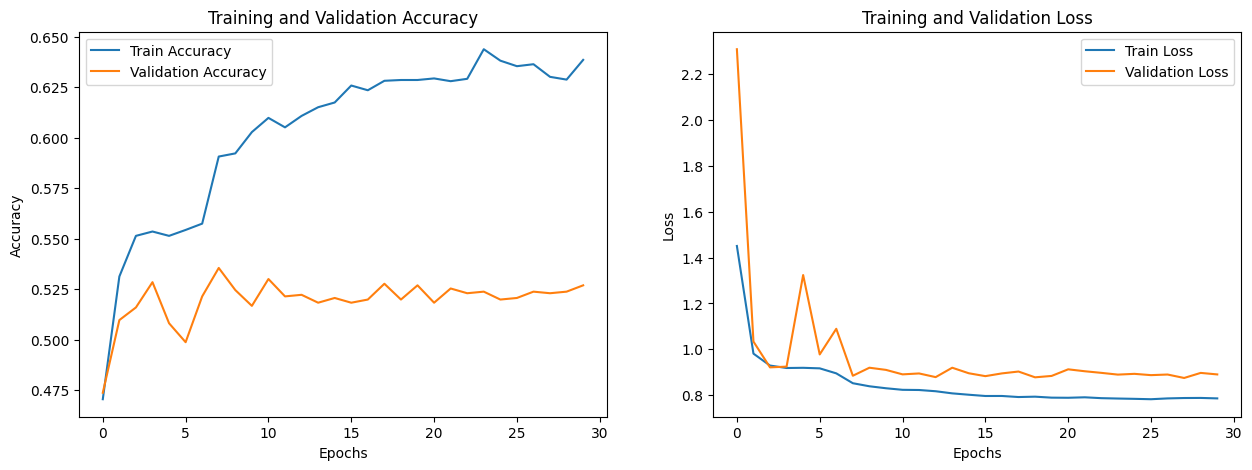

In [7]:
# Result visualization
import matplotlib.pyplot as plt
print("ResNet50 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(val_labels, val_preds))

## MobileNetV2

In [4]:
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading MobileNetV2 for training from scratch ...\n")
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading MobileNetV2 for training from scratch ...

Model Summary:



Using cache found in C:\Users\HanDong/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\MobileNetV2_model.pth")

Training:

Epoch 0/29
----------
train Loss: 1.7714 Acc: 0.3134
valid Loss: 9.3223 Acc: 0.0086

Epoch 1/29
----------
train Loss: 0.8602 Acc: 0.5743
valid Loss: 0.8665 Acc: 0.5278

Epoch 2/29
----------
train Loss: 0.6839 Acc: 0.6905
valid Loss: 0.8887 Acc: 0.5082

Epoch 3/29
----------
train Loss: 0.5816 Acc: 0.7373
valid Loss: 1.1514 Acc: 0.4238

Epoch 4/29
----------
train Loss: 0.4865 Acc: 0.7777
valid Loss: 1.7828 Acc: 0.3581

Epoch 5/29
----------
train Loss: 0.4214 Acc: 0.8111
valid Loss: 0.8926 Acc: 0.5082

Epoch 6/29
----------
train Loss: 0.3564 Acc: 0.8474
valid Loss: 2.4068 Acc: 0.2291

Epoch 7/29
----------
train Loss: 0.2646 Acc: 0.8980
valid Loss: 0.6593 Acc: 0.6403

Epoch 8/29
----------
train Loss: 0.2075 Acc: 0.9288
valid Loss: 0.5501 Acc: 0.6959

Epoch 9/29
----------
train Loss: 0.1731 Acc: 0.9478
valid Loss: 0.5144 Acc: 0.7076

Epoch 10/29
----------
train Loss: 0.1521 Acc: 0.9570
valid Loss: 0.5779 Acc: 0.6865

Epoch 11/29
----------
train Loss: 0.1266 Acc: 0.9704

## Evaluation

MobileNetv2 model:


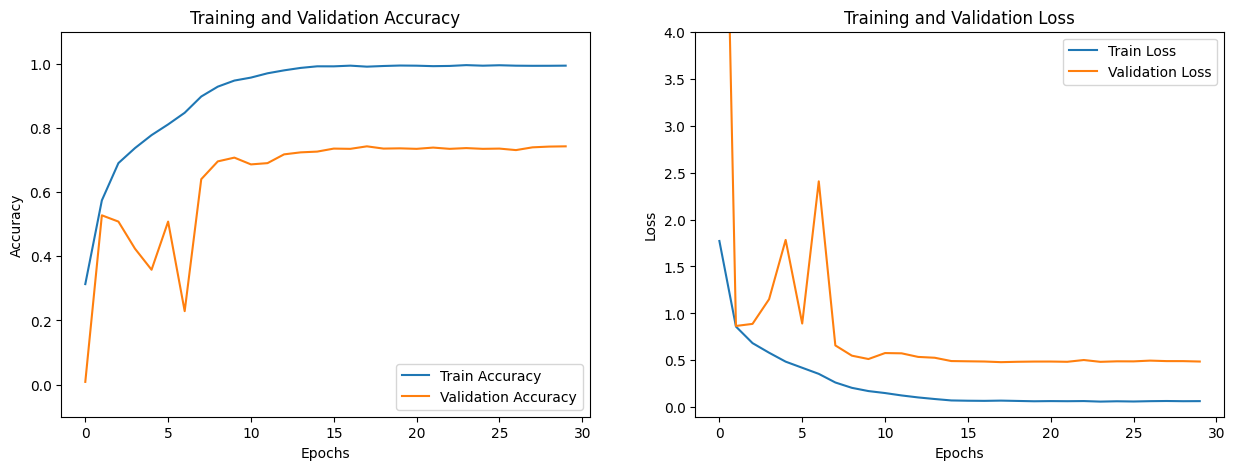

In [26]:
# Result visualization
import matplotlib.pyplot as plt
print("MobileNetv2 model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(-0.1, 4)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

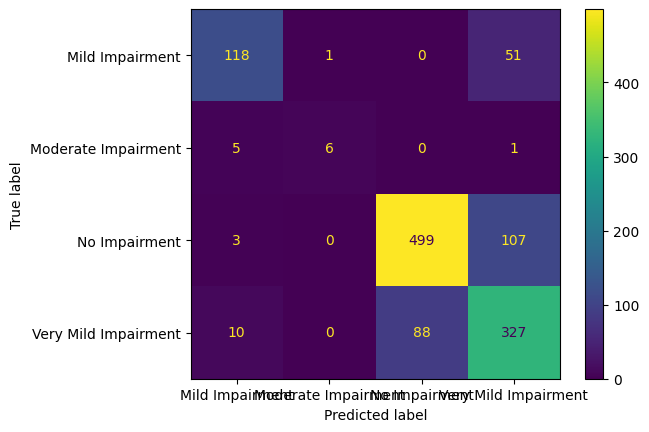

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [9]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       170
           1       0.86      0.50      0.63        12
           2       0.85      0.82      0.83       609
           3       0.67      0.77      0.72       425

    accuracy                           0.78      1216
   macro avg       0.81      0.70      0.74      1216
weighted avg       0.79      0.78      0.78      1216



### MobileNetV2_pretrained

In [4]:
from torchinfo import summary

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Loading MobileNetV2 for training from scratch ...\n")
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

# Transfer the model to GPU
model_ft = model.to(device)

# Print model summary
print('Model Summary:\n')
summary(model_ft, input_size=(1, 3, 224, 224))
print(model_ft)

Loading MobileNetV2 for training from scratch ...



Using cache found in C:\Users\HanDong/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\HanDong/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:26<00:00, 546kB/s]


Model Summary:

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Batc

In [6]:
# Train the model
print("Training:\n")
model_ft, train_accuracy, train_losses, val_accuracy, val_losses, val_preds, val_labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.cuda.empty_cache()

# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, PATH + "\\MobileNetV2_pretrained.pth")

Training:

Epoch 0/29
----------
train Loss: 0.9537 Acc: 0.7619
valid Loss: 0.5676 Acc: 0.7162

Epoch 1/29
----------
train Loss: 0.2148 Acc: 0.9151
valid Loss: 0.5565 Acc: 0.7263

Epoch 2/29
----------
train Loss: 0.0847 Acc: 0.9723
valid Loss: 0.2790 Acc: 0.8468

Epoch 3/29
----------
train Loss: 0.0336 Acc: 0.9920
valid Loss: 0.2040 Acc: 0.8749

Epoch 4/29
----------
train Loss: 0.0134 Acc: 0.9973
valid Loss: 0.1622 Acc: 0.8898

Epoch 5/29
----------
train Loss: 0.0068 Acc: 0.9989
valid Loss: 0.1496 Acc: 0.8976

Epoch 6/29
----------
train Loss: 0.0042 Acc: 0.9996
valid Loss: 0.1209 Acc: 0.9109

Epoch 7/29
----------
train Loss: 0.0025 Acc: 1.0000
valid Loss: 0.1132 Acc: 0.9124

Epoch 8/29
----------
train Loss: 0.0028 Acc: 0.9999
valid Loss: 0.1111 Acc: 0.9140

Epoch 9/29
----------
train Loss: 0.0020 Acc: 0.9999
valid Loss: 0.1204 Acc: 0.9109

Epoch 10/29
----------
train Loss: 0.0019 Acc: 0.9999
valid Loss: 0.1131 Acc: 0.9124

Epoch 11/29
----------
train Loss: 0.0018 Acc: 1.0000

MobileNetv2_pretrained model:


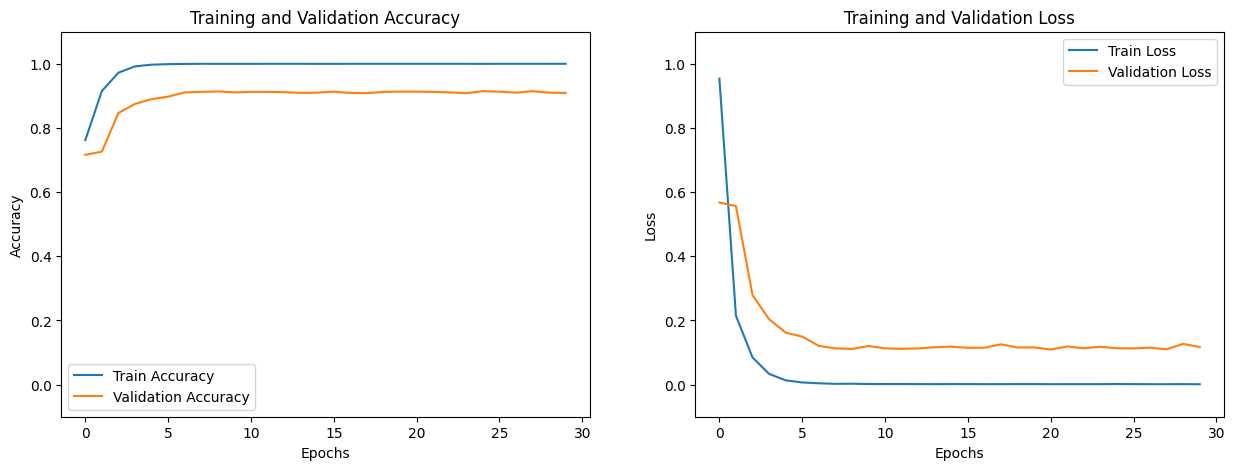

In [17]:
# Result visualization
import matplotlib.pyplot as plt
print("MobileNetv2_pretrained model:")
plt.figure(figsize=(15,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

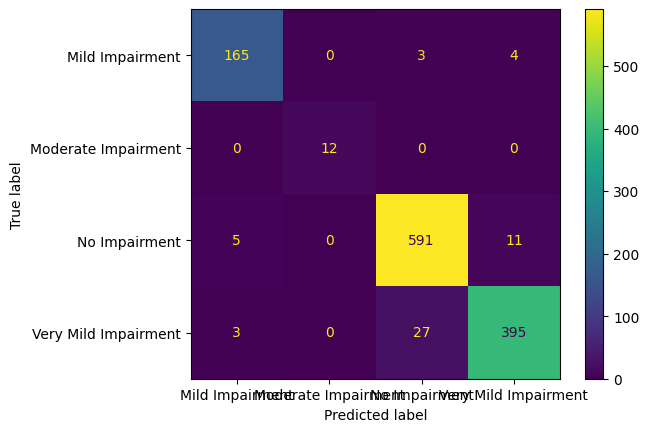

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(val_labels,val_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment'])
cm_display.plot()
plt.show()

In [9]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       172
           1       1.00      1.00      1.00        12
           2       0.95      0.97      0.96       607
           3       0.96      0.93      0.95       425

    accuracy                           0.96      1216
   macro avg       0.97      0.97      0.97      1216
weighted avg       0.96      0.96      0.96      1216



### Saliency map

True Label: Mild Impairment
Predicted Label: No Impairment


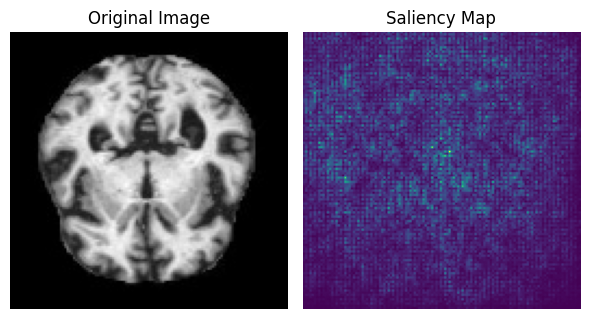

In [40]:
def generate_saliency_map(model, image, label, class_names):
    """
    Generate and display a saliency map for a single image.
    
    Parameters:
        model: Trained PyTorch model.
        image: Input image in PIL.Image format.
        label: True label of the image (integer).
        class_names: List of class names.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert the image (PIL.Image) to a PyTorch tensor
    transform = transforms.ToTensor()  # Converts to tensor and scales to [0, 1]
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Enable gradient computation for the image
    image.requires_grad_()

    # Forward pass
    output = model(image)
    _, predicted_class = torch.max(output, 1)

    print(f"True Label: {class_names[label]}")
    print(f"Predicted Label: {class_names[predicted_class.item()]}")

    # Get the score for the predicted class
    score = output[0, predicted_class]

    # Backward pass to compute gradients
    model.zero_grad()
    score.backward()

    # Get the gradients of the input image
    saliency = image.grad.data.abs().squeeze(0)  # Remove batch dimension

    # Convert to NumPy for visualization
    saliency = saliency.max(dim=0)[0].cpu().numpy()  # Take max along channel dimension

    # Plot the original image and the saliency map
    fig, ax = plt.subplots(1, 2, figsize=(6, 6))

    # Original image
    original_image = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Saliency map
    ax[1].imshow(saliency)
    ax[1].set_title("Saliency Map")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Select an image and label from the dataset
image, label = test_dataset[0]  # Replace 0 with the desired index
generate_saliency_map(model, image, label, class_names=labels)